In [1]:
import os,sys
sys.path.append("..")
import numpy as np
import pandas as pd
import ibmseti
import collections
import scipy.io
import matplotlib.pyplot as plt
import commonutils as cu
import PIL
from PIL import Image

Using TensorFlow backend.


In [2]:
import keras
from keras import backend as K
K.set_image_dim_ordering('tf')
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

# Experimenting with images

In [13]:
### Loading saved npy files
# Loading in saved subset of data files 
subsetComplexSignals = np.load('../data/complexSignalsSubset.npy')[()]
subsetSpectrograms = np.load('../data/specSubset.npy')[()]

## Trying out binning techniques

Trying out some code from https://gist.github.com/derricw/95eab740e1b08b78c03f to average along x-axis. 
Also experimenting with reshaping / resizing the image

In [14]:
def showImageFromSpec(spec,imsize,binFactor,save=False,filename=None):
    specShape = spec.shape
    spec = cu.nputils.bin_ndarray(spec[1:,:],(specShape[0]-1,specShape[1]/binFactor),operation='average')
    dpi = 96.0
    fig = plt.figure(frameon=False,figsize=(imsize[0]/dpi,imsize[1]/dpi))
    ax = plt.Axes(fig,[0.,0.,1.,1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    # fig, ax = plt.subplots(figsize=(20, 10))
    # ax.imshow(np.log(spec), aspect = 0.5*float(spec.shape[1]) / spec.shape[0])
    plt.set_cmap('jet')
    ax.imshow(np.log(spec), aspect = 'auto')
    plt.show()

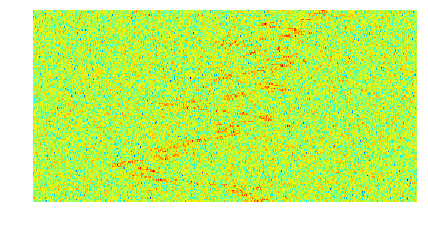

In [15]:
# spec = subsetSpectrograms['narrowband'][1]
# spec = subsetSpectrograms['squiggle'][1]
# spec = subsetSpectrograms['squigglesquarepulsednarrowband'][2]
spec = subsetSpectrograms['squiggle'][1]
showImageFromSpec(spec,(512,256),4,save=False,filename="resized_spec")

In [16]:
np.max(subsetSpectrograms['noise'][1])

31556838.07360312

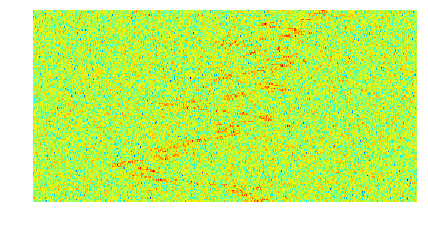

In [17]:
# Using code from https://gist.github.com/derricw/95eab740e1b08b78c03f, reducing along x axis
# Seeing how much file can be reduced in size. Ignoring first row to make it 128x6144
# Then factoring down on x-axis by 3 to 128x2048
showImageFromSpec(spec,(512,256),4,save=False,filename="resized_spec")

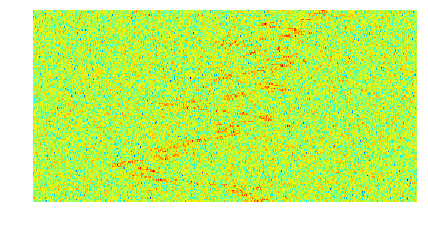

In [18]:
# Using code from https://gist.github.com/derricw/95eab740e1b08b78c03f, reducing along x axis
# Seeing how much file can be reduced in size. Ignoring first row to make it 128x6144
# Then factoring down on x-axis by 6 to 128x1024
showImageFromSpec(spec,(512,256),4,save=False,filename="resized_spec")

## Converting all files to images (skip if already exists)

In [9]:
# Run through directory 
specPath = "../data/specdataraw/"
binFactor = 4
image_size = (256,128)
savePath = "../data/specdataimages_{}x{}_{}/".format(image_size[0],image_size[1],binFactor)
os.system("mkdir -p "+savePath)
specfiles = [f for f in os.listdir(specPath) if os.path.isfile(os.path.join(specPath, f))]
for i in range(len(specfiles)):
    # Convert and save each file as image
    fname = specfiles[i].split(".")[0]
    print "\r{0}".format(i),
    spec = np.load("{}{}.npy".format(specPath,fname))
    cu.datautils.saveImageFromSpec(spec,image_size,binFactor,colmap=None,save=True,filename="{}{}".format(savePath,fname))

15984                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

## Saving a sample of images - to send to Andreas

In [12]:
subsetSpectrograms.keys()

['noise',
 'squiggle',
 'narrowbanddrd',
 'brightpixel',
 'narrowband',
 'squigglesquarepulsednarrowband',
 'squarepulsednarrowband']

In [ ]:
for key in subsetSpectrograms.keys():
    for i in range(len(subsetSpectrograms[key])):
        %%system mkdir -p sampleImages_small_size
        spec = subsetSpectrograms[key][i]
        fname = "./sampleImages_small_size/{}_{}".format(key,i)
        cu.datautils.saveImageFromSpec(spec,(224,224),save=True,filename=fname) # Creating smaller size images!

# VGG Model activations

## Individually examining activations

In [5]:
# Loading in table with info on files
fileListDF = pd.read_csv("../data/fileList.csv")
# Loading in an arbitrary file
imgPath = "../data/specdataimages_512x224_4/"
fnum = 110
imgfiles = [f for f in os.listdir(imgPath) if os.path.isfile(os.path.join(imgPath, f))]
image = np.asarray(Image.open(os.path.join(imgPath,imgfiles[fnum])))
print imgfiles[fnum]
print fileListDF.ix[int(imgfiles[fnum].split(".")[0])]

002510.jpg
file_name                285e3f79-b74b-46b0-b795-fde92a8de646.dat
signal_classification                               narrowbanddrd
uuid                         285e3f79-b74b-46b0-b795-fde92a8de646
file_index                                                   2510
label                                                           3
dataset                                                     train
Name: 2510, dtype: object


viridis


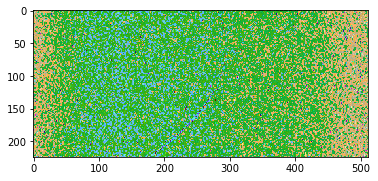

In [6]:
image = image.astype('float32')
image = np.expand_dims(image,axis=0)
image = preprocess_input(image)
print plt.get_cmap().name
plt.imshow(image[0])
plt.show()

In [7]:
# Loading in the model
base_model = VGG16(weights='imagenet', include_top=False)

In [8]:
base_model.output_shape[1:]

(None, None, 512)

In [9]:
from model_specs import vgg_fine_tune

In [ ]:
model = vgg_fine_tune.build(nb_classes=)

In [5]:

# Loading in the model
base_model = VGG16(weights='imagenet', include_top=False)


# Viewing VGG activations on the entire image 
imageAct = cu.datautils.modelActivations(model=base_model,input=image,poolfit=None,save=True,show=True)

7


IndexError: Not figured out how to layout 7 activations yet

## Generating all activations (skip if already exists)

In [6]:
# Point to directory
# Call model activations function
readDir = "../data/specdataimages_512x224_4/"
writeDir = "../data/specdataactivations_512x224_4_fine_tune/"
layerName = "block5_pool"
poolfitSize = None
cu.datautils.generateAllActivations(readDir,writeDir,layerName,poolfitSize)

UnboundLocalError: local variable 'model' referenced before assignment

## Creating combined activations file (skip if done)

In [4]:
fileListDF = pd.read_csv("fileList.csv",dtype={'file_index':str})
fileListDF.groupby("signal_classification").count()

,file_name,uuid,file_index,label
signal_classification,,,,
brightpixel,2000,2000,2000,2000
narrowband,1997,1997,1997,1997
narrowbanddrd,3995,3995,3995,3995
noise,1998,1998,1998,1998
squarepulsednarrowband,1998,1998,1998,1998
squiggle,1997,1997,1997,1997
squigglesquarepulsednarrowband,2000,2000,2000,2000


In [5]:
## Assigning numbers to classes
labelMap = {'noise':0,'brightpixel':1,'narrowband':2,
            'narrowbanddrd':3,'squarepulsednarrowband':4,'squiggle':5,'squigglesquarepulsednarrowband':6}
# fileListDF["label"] = fileListDF["signal_classification"].apply(lambda x: labelMap[x])
# fileListDF.to_csv("fileList.csv",index=False)
print labelMap
fileListDF.ix[0:5]

{'noise': 0, 'squiggle': 5, 'narrowbanddrd': 3, 'brightpixel': 1, 'narrowband': 2, 'squigglesquarepulsednarrowband': 6, 'squarepulsednarrowband': 4}


,file_name,signal_classification,uuid,file_index,label
0,00069203-0824-4136-9c99-b9f68672f23d.dat,squigglesquarepulsednarrowband,00069203-0824-4136-9c99-b9f68672f23d,000000,6
1,000739aa-89d6-4965-abf6-9b46a246604a.dat,narrowband,000739aa-89d6-4965-abf6-9b46a246604a,000001,2
2,000874dd-8d6e-44b1-8ade-21aeb5a29546.dat,narrowbanddrd,000874dd-8d6e-44b1-8ade-21aeb5a29546,000002,3
3,0009073c-4032-4b84-832a-9b81fc3b0df8.dat,brightpixel,0009073c-4032-4b84-832a-9b81fc3b0df8,000003,1
4,000c28b3-aeba-4f18-ac60-b91341921264.dat,squigglesquarepulsednarrowband,000c28b3-aeba-4f18-ac60-b91341921264,000004,6
5,000eb18b-326f-4488-9f07-b7382c01bf91.dat,narrowband,000eb18b-326f-4488-9f07-b7382c01bf91,000005,2


## Combine all activations from folder and save to a file 

In [25]:
## Read in all files from directory and combine them into train/val/test datasets
readDir = "../data/specdataactivations_block5_256x128_4/"
nvalidation = 3000
ntest = 1500
cu.datautils.createDataset(readDir,"../data/fileList.csv",'../data/activations-5-21-block5-256*128.h5',loadImages=True)

OSError: [Errno 2] No such file or directory: '../data/specdataactivations_block5_256x128_4/'

In [15]:
dataset.keys()

NameError: name 'dataset' is not defined